In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms # 处理数据模块

# 数据准备 

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: E:/jupyter/Study/caicai/5_神经网络的学习
    Split: Train
    StandardTransform
Transform: ToTensor()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])

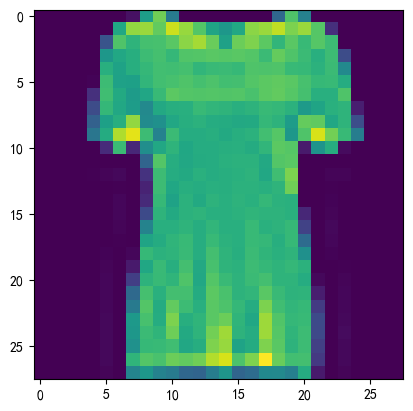

In [2]:
# 实例化数据
mnist = torchvision.datasets.FashionMNIST(root="E:/jupyter/Study/caicai/5_神经网络的学习" # 计算机上某个目录路径
                                          ,download = False # 是否允许下载
                                          ,train = True # 是否是训练集数据
                                          ,transform = transforms.ToTensor() #对数据集进行统一处理
                                         )
mnist
# 标签
mnist.targets.unique()
# 标签编码对应真正的类别
mnist.classes

# 打印数据集
mnist[10][0].shape
plt.imshow(mnist[10][0].view(28,28).numpy())

In [3]:
# 确定数据，确定超参数
lr = 0.15
gamma = 0.2
epochs = 10
bs = 128

In [4]:
# 切分小批量
batchdata = DataLoader(mnist
                      ,batch_size = bs
                      ,shuffle = True)

# 查看切分后的shape
for x,y in batchdata:
    print(x.shape)
    print(y.shape)
    break;

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [5]:
# 输入
input_ = mnist.data[0].numel()# 拉平二维图像
# 输出
output_ = len(mnist.targets.unique()) 
input_
output_

784

10

# 构建模型 

## 定义网络架构 

In [62]:
# 定义神经网络的架构
class Model(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.normalize = nn.BatchNorm2d(num_features=1)
        self.linear1 = nn.Linear(in_features,128,bias=False)
        self.output = nn.Linear(128,out_features,bias=False)
        
    def forward(self,x):
        x = self.normalize(x)
        x = x.view(-1,28*28)
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = F.log_softmax(self.output(sigma1),dim=1)
        return sigma2

In [38]:
import torch
from torch import nn
from torchvision import models as m
from torchinfo import summary

vgg16_bn_ = m.vgg16_bn()
resnet18_ = m.resnet18()

In [57]:
resnet18_
#resnet18_.layer3[0].conv1 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#resnet18_.layer3[0].downsample[0] = nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
#resnet18_.layer3[1].conv2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
vgg16_bn_ = m.vgg16_bn()
resnet18_ = m.resnet18()
class MyNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
                                   ,nn.BatchNorm2d(64)
                                   ,nn.ReLU(inplace=True)
                                  )
        self.block2 = vgg16_bn_.features[7:14]
        self.block3 = resnet18_.layer3
        self.avgpool = resnet18_.avgpool #-> 1x1
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.block3(self.block2(x))
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = F.log_softmax(self.fc(x),dim=1)
        return x

data = torch.ones(10,1,32,32)
summary(MyNet1(),input_size=(10,1,32,32),depth=3,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyNet1                                   [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [10, 64, 32, 32]          640
│    └─BatchNorm2d: 2-2                  [10, 64, 32, 32]          128
│    └─ReLU: 2-3                         [10, 64, 32, 32]          --
├─Sequential: 1-2                        [10, 128, 16, 16]         --
│    └─Conv2d: 2-4                       [10, 128, 32, 32]         73,856
│    └─BatchNorm2d: 2-5                  [10, 128, 32, 32]         256
│    └─ReLU: 2-6                         [10, 128, 32, 32]         --
│    └─Conv2d: 2-7                       [10, 128, 32, 32]         147,584
│    └─BatchNorm2d: 2-8                  [10, 128, 32, 32]         256
│    └─ReLU: 2-9                         [10, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [10, 128, 16, 16]         --
├─

In [15]:
vgg16_bn_ = m.vgg16_bn()
resnet18_ = m.resnet18()
class MyNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
                                   ,nn.BatchNorm2d(64)
                                   ,nn.ReLU(inplace=True)
                                  )
        self.block2 = vgg16_bn_.features[7:14]
        self.block3 = resnet18_.layer2[1]
        self.block4 = resnet18_.layer3[0]
        self.avgpool = resnet18_.avgpool #-> 1x1
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.block4(self.block3(self.block2(x)))
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = F.log_softmax(self.fc(x),dim=1)
        return x

data = torch.ones(10,1,32,32)
summary(MyNet2(),input_size=(10,1,32,32),depth=3,device="cpu")

NameError: name 'summary' is not defined

In [6]:
class BasicConv2d(nn.Module):
    def __init__(self,in_,out_=10,**kwargs):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_,out_,**kwargs)
                                  ,nn.BatchNorm2d(out_)
                                  ,nn.ReLU(inplace=True)
                                 )
    def forward(self,x):
        x = self.conv(x)
        return x
    
class MyNet3(nn.Module):
    def __init__(self,in_channels=1,out_features=10):
        super().__init__()
        self.block1 = nn.Sequential(BasicConv2d(in_ = in_channels,out_=32,kernel_size=5,padding=2)
                                    ,BasicConv2d(32,32,kernel_size=5,padding=2)
                                    ,nn.MaxPool2d(2)
                                    ,nn.Dropout2d(0.25))
        self.block2 = nn.Sequential(BasicConv2d(32,64,kernel_size=3,padding=1)
                                   ,BasicConv2d(64,64,kernel_size=3,padding=1)
                                   ,BasicConv2d(64,64,kernel_size=3,padding=1)
                                   ,nn.MaxPool2d(2)
                                   ,nn.Dropout2d(0.25))
        
        self.classifier_ = nn.Sequential(
            nn.Linear(64*7*7,256)
            ,nn.BatchNorm1d(256) #此时数据已是二维，因此需要BatchNorm1d
            ,nn.ReLU(inplace=True)
            ,nn.Linear(256,out_features)
            ,nn.LogSoftmax(1)
        )
        
    def forward(self,x):
        x = self.block2(self.block1(x))
        x = x.view(-1, 64*7*7)
        output = self.classifier_(x)
        return output

## 定义训练过程 

In [11]:
# 定义一个训练函数
def fit_(net,batchdata,lr=0.01,epochs=5,gamma=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 将模型移到GPU上
    net.to(device)

    # 定义损失函数
    criterion = nn.NLLLoss()
    # 定义优化算法
    #opt = optim.SGD(net.parameters(),lr=lr,momentum=gamma)
    opt = optim.Adam(net.parameters(), lr=lr)

    # correct和samples可以没有，为了求解准确率定义的
    # 预测正确的样本数量
    correct = 0
    # 模型训练过的样本数量
    samples = 0
    
    for epoch in range(epochs):# 全数据被训练几次
        # enumerate 给元素加索引
        for batch_idx,(x,y) in enumerate(batchdata):
            x, y = x.to(device), y.to(device)  # 将数据移到GPU上
            
            y = y.view(x.shape[0]) # 多分类将label将为一维防止报错
            # 向前传播
            sigma = net.forward(x) 
            # 计算损失函数值
            loss = criterion(sigma,y)
            # 反向传播 - 得到梯度
            loss.backward()
            # 更新权重和动量
            opt.step()# 更新权重w, 更新动量v
            # 清空梯度
            opt.zero_grad()
            
            # 求解准确率
            yhat = torch.max(sigma,1)[1]
            correct += torch.sum(yhat == y)

            # 每次训练一个batch，模型训练过的样本数量加x.shape[0]
            samples += x.shape[0]
        
            if (batch_idx+1)%125 == 0 or batch_idx == len(batchdata)-1:
                print(f"Epoch{epoch+1}:[{samples}/{epochs*len(batchdata.dataset)}({100*samples/(epochs*len(batchdata.dataset)):.2f})%],Loss:{loss.data.item():.2f},Accuracy:{100*correct/samples:.2f}%")

In [63]:
# 模型训练与评估
torch.manual_seed(420)
net = Model(in_features=input_,out_features=output_)
fit_(net,batchdata,lr=lr,epochs=epochs,gamma=gamma)

Epoch1:[16000/600000(2.67)%],Loss:0.55,Accuracy:74.66%
Epoch1:[32000/600000(5.33)%],Loss:0.46,Accuracy:78.55%
Epoch1:[48000/600000(8.00)%],Loss:0.37,Accuracy:80.33%
Epoch1:[60000/600000(10.00)%],Loss:0.38,Accuracy:81.15%
Epoch2:[76000/600000(12.67)%],Loss:0.47,Accuracy:82.19%
Epoch2:[92000/600000(15.33)%],Loss:0.31,Accuracy:82.91%
Epoch2:[108000/600000(18.00)%],Loss:0.35,Accuracy:83.38%
Epoch2:[120000/600000(20.00)%],Loss:0.39,Accuracy:83.75%
Epoch3:[136000/600000(22.67)%],Loss:0.34,Accuracy:84.19%
Epoch3:[152000/600000(25.33)%],Loss:0.34,Accuracy:84.62%
Epoch3:[168000/600000(28.00)%],Loss:0.42,Accuracy:84.95%
Epoch3:[180000/600000(30.00)%],Loss:0.30,Accuracy:85.16%
Epoch4:[196000/600000(32.67)%],Loss:0.35,Accuracy:85.47%
Epoch4:[212000/600000(35.33)%],Loss:0.29,Accuracy:85.71%
Epoch4:[228000/600000(38.00)%],Loss:0.30,Accuracy:85.91%
Epoch4:[240000/600000(40.00)%],Loss:0.29,Accuracy:86.05%
Epoch5:[256000/600000(42.67)%],Loss:0.36,Accuracy:86.27%
Epoch5:[272000/600000(45.33)%],Loss:0.14

In [67]:
# 模型训练与评估
torch.manual_seed(420)
net1 = MyNet1()
fit_(net1,batchdata,lr=lr,epochs=epochs,gamma=gamma)

Epoch1:[16000/600000(2.67)%],Loss:0.41,Accuracy:69.83%
Epoch1:[32000/600000(5.33)%],Loss:0.60,Accuracy:76.70%
Epoch1:[48000/600000(8.00)%],Loss:0.36,Accuracy:79.71%
Epoch1:[60000/600000(10.00)%],Loss:0.36,Accuracy:81.20%
Epoch2:[76000/600000(12.67)%],Loss:0.25,Accuracy:82.79%
Epoch2:[92000/600000(15.33)%],Loss:0.25,Accuracy:84.07%
Epoch2:[108000/600000(18.00)%],Loss:0.22,Accuracy:84.94%
Epoch2:[120000/600000(20.00)%],Loss:0.22,Accuracy:85.47%
Epoch3:[136000/600000(22.67)%],Loss:0.17,Accuracy:86.20%
Epoch3:[152000/600000(25.33)%],Loss:0.30,Accuracy:86.72%
Epoch3:[168000/600000(28.00)%],Loss:0.42,Accuracy:87.22%
Epoch3:[180000/600000(30.00)%],Loss:0.20,Accuracy:87.54%
Epoch4:[196000/600000(32.67)%],Loss:0.18,Accuracy:87.99%
Epoch4:[212000/600000(35.33)%],Loss:0.20,Accuracy:88.35%
Epoch4:[228000/600000(38.00)%],Loss:0.19,Accuracy:88.69%
Epoch4:[240000/600000(40.00)%],Loss:0.25,Accuracy:88.91%
Epoch5:[256000/600000(42.67)%],Loss:0.16,Accuracy:89.24%
Epoch5:[272000/600000(45.33)%],Loss:0.22

In [73]:
# 模型训练与评估
torch.manual_seed(420)
net2 = MyNet2()
fit_(net2,batchdata,lr=lr,epochs=epochs,gamma=gamma)

Epoch1:[16000/600000(2.67)%],Loss:0.48,Accuracy:69.69%
Epoch1:[32000/600000(5.33)%],Loss:0.65,Accuracy:76.19%
Epoch1:[48000/600000(8.00)%],Loss:0.35,Accuracy:79.27%
Epoch1:[60000/600000(10.00)%],Loss:0.39,Accuracy:80.81%
Epoch2:[76000/600000(12.67)%],Loss:0.26,Accuracy:82.38%
Epoch2:[92000/600000(15.33)%],Loss:0.26,Accuracy:83.63%
Epoch2:[108000/600000(18.00)%],Loss:0.21,Accuracy:84.52%
Epoch2:[120000/600000(20.00)%],Loss:0.22,Accuracy:85.07%
Epoch3:[136000/600000(22.67)%],Loss:0.19,Accuracy:85.77%
Epoch3:[152000/600000(25.33)%],Loss:0.29,Accuracy:86.31%
Epoch3:[168000/600000(28.00)%],Loss:0.51,Accuracy:86.81%
Epoch3:[180000/600000(30.00)%],Loss:0.22,Accuracy:87.13%
Epoch4:[196000/600000(32.67)%],Loss:0.24,Accuracy:87.55%
Epoch4:[212000/600000(35.33)%],Loss:0.29,Accuracy:87.89%
Epoch4:[228000/600000(38.00)%],Loss:0.25,Accuracy:88.24%
Epoch4:[240000/600000(40.00)%],Loss:0.26,Accuracy:88.46%
Epoch5:[256000/600000(42.67)%],Loss:0.17,Accuracy:88.77%
Epoch5:[272000/600000(45.33)%],Loss:0.22

In [9]:
# 模型训练与评估
torch.manual_seed(420)
net3 = MyNet3(out_features=output_)
fit_(net3,batchdata,lr=lr,epochs=epochs,gamma=gamma)

Epoch1:[16000/600000(2.67)%],Loss:0.42,Accuracy:80.24%
Epoch1:[32000/600000(5.33)%],Loss:0.32,Accuracy:83.43%
Epoch1:[48000/600000(8.00)%],Loss:0.24,Accuracy:85.14%
Epoch1:[60000/600000(10.00)%],Loss:0.39,Accuracy:85.82%
Epoch2:[76000/600000(12.67)%],Loss:0.24,Accuracy:86.70%
Epoch2:[92000/600000(15.33)%],Loss:0.26,Accuracy:87.28%
Epoch2:[108000/600000(18.00)%],Loss:0.22,Accuracy:87.78%
Epoch2:[120000/600000(20.00)%],Loss:0.16,Accuracy:88.11%
Epoch3:[136000/600000(22.67)%],Loss:0.22,Accuracy:88.48%
Epoch3:[152000/600000(25.33)%],Loss:0.24,Accuracy:88.81%
Epoch3:[168000/600000(28.00)%],Loss:0.20,Accuracy:89.06%
Epoch3:[180000/600000(30.00)%],Loss:0.22,Accuracy:89.27%
Epoch4:[196000/600000(32.67)%],Loss:0.28,Accuracy:89.52%
Epoch4:[212000/600000(35.33)%],Loss:0.26,Accuracy:89.75%
Epoch4:[228000/600000(38.00)%],Loss:0.26,Accuracy:89.93%
Epoch4:[240000/600000(40.00)%],Loss:0.15,Accuracy:90.07%
Epoch5:[256000/600000(42.67)%],Loss:0.22,Accuracy:90.27%
Epoch5:[272000/600000(45.33)%],Loss:0.19

In [13]:
# 模型训练与评估
torch.manual_seed(420)
net3 = MyNet3(out_features=output_)
fit_(net3,batchdata,lr=0.001,epochs=epochs)

Epoch1:[16000/600000(2.67)%],Loss:0.35,Accuracy:80.96%
Epoch1:[32000/600000(5.33)%],Loss:0.28,Accuracy:84.16%
Epoch1:[48000/600000(8.00)%],Loss:0.22,Accuracy:85.68%
Epoch1:[60000/600000(10.00)%],Loss:0.26,Accuracy:86.38%
Epoch2:[76000/600000(12.67)%],Loss:0.24,Accuracy:87.26%
Epoch2:[92000/600000(15.33)%],Loss:0.22,Accuracy:87.74%
Epoch2:[108000/600000(18.00)%],Loss:0.25,Accuracy:88.15%
Epoch2:[120000/600000(20.00)%],Loss:0.17,Accuracy:88.49%
Epoch3:[136000/600000(22.67)%],Loss:0.21,Accuracy:88.88%
Epoch3:[152000/600000(25.33)%],Loss:0.21,Accuracy:89.19%
Epoch3:[168000/600000(28.00)%],Loss:0.21,Accuracy:89.44%
Epoch3:[180000/600000(30.00)%],Loss:0.17,Accuracy:89.64%
Epoch4:[196000/600000(32.67)%],Loss:0.23,Accuracy:89.91%
Epoch4:[212000/600000(35.33)%],Loss:0.20,Accuracy:90.12%
Epoch4:[228000/600000(38.00)%],Loss:0.25,Accuracy:90.29%
Epoch4:[240000/600000(40.00)%],Loss:0.15,Accuracy:90.41%
Epoch5:[256000/600000(42.67)%],Loss:0.22,Accuracy:90.61%
Epoch5:[272000/600000(45.33)%],Loss:0.18

In [2]:
import torch
from torch import nn
from torchvision import models as m

In [9]:
res18pt = m.resnet18(pretrained=True)

f:\app2\Anaconda\envs\pytorch3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\app2\Anaconda\envs\pytorch3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
res18pt = m.resnet18(weights='DEFAULT')
res18pt.conv1.weight[0][0]

tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]],
       grad_fn=<SelectBackward0>)

In [23]:
res18pt = m.resnet18(weights='IMAGENET1K_V1')
res18pt.conv1.weight[0][0]

tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]],
       grad_fn=<SelectBackward0>)

In [24]:
resnet18_.conv1.weight[0][0]

tensor([[-1.1997e-02,  3.2418e-02,  8.8922e-03,  1.7633e-02, -4.0451e-03,
         -4.0831e-02, -1.3448e-02],
        [-1.2586e-02,  9.3377e-03, -2.1951e-02,  4.5489e-03, -1.1026e-02,
         -3.7333e-03, -1.3121e-02],
        [ 2.6318e-05, -1.1540e-02, -5.1314e-03,  4.0690e-02, -2.3519e-02,
         -5.5018e-03, -9.5371e-03],
        [ 1.5426e-02,  7.0454e-02,  1.7844e-02,  3.8229e-02, -3.8968e-02,
          2.6191e-02, -1.9457e-02],
        [ 3.7230e-02, -5.7666e-03,  4.0124e-03, -4.5354e-03,  1.0143e-02,
         -4.9118e-02, -4.9631e-02],
        [ 2.6891e-02,  2.9218e-02,  2.5833e-02, -3.5628e-03,  1.8920e-02,
         -8.4390e-03, -3.4539e-03],
        [ 3.4206e-02, -4.8687e-02,  2.0985e-03, -4.1109e-02, -6.0052e-03,
         -1.3575e-02,  4.3677e-02]], grad_fn=<SelectBackward0>)